In [1]:
import math, os, random, sys, time, logging
import numpy as np
import tensorflow as tf
import data_utils
import seq2seq_model
from six.moves import xrange

In [2]:
learning_rate = 0.5 # ratio de aprendizaje
learning_rate_decay_factor = 0.99 # decay del ratio de aprendizaje
max_gradient_norm = 5.0 # maxima norma de las gradientes (regularizacion)
batch_size = 256 # Tamaño de los batch de entrenamiento
size = 512 # Tamaño de las capas del modelo
num_layers = 2 # Numero de capas
from_vocab_size = 40000 # Tamaño del vocabulario en ingles
to_vocab_size = 40000 # Tamaño del vocabulario en frances
data_dir = 'results' # Directorio de la data
train_dir = 'train' # Directorio de entrenamiento
max_train_data_size = 6500000 # Limite del tamaño de la data de entrenamiento (0: no limite)
steps_per_checkpoint = 100 # Cada cuantos pasos se guarda un checkpoint
use_fp16 = False # Usar precision decimal de 16 bits

# Archivos de vocabulario:
# from_train_data = None
# to_train_data = None
# from_dev_data = None
# to_dev_data = None

# Duplas de buckets a usar en el preprocesamiento de la data (ingles, frances).
_buckets = [(5, 10), (10, 15), (20, 25), (40, 50)]

In [3]:
def read_data(source_path, target_path, max_size=None):
    """Read data from source and target files and put into buckets.
    Args:
    source_path: path to the files with token-ids for the source language.
    target_path: path to the file with token-ids for the target language;
        it must be aligned with the source file: n-th line contains the desired
        output for n-th line from the source_path.
    max_size: maximum number of lines to read, all other will be ignored;
        if 0 or None, data files will be read completely (no limit).
    Returns:
    data_set: a list of length len(_buckets); data_set[n] contains a list of
        (source, target) pairs read from the provided data files that fit
        into the n-th bucket, i.e., such that len(source) < _buckets[n][0] and
        len(target) < _buckets[n][1]; source and target are lists of token-ids.
    """
    data_set = [[] for _ in _buckets]
    with tf.gfile.GFile(source_path, mode="r") as source_file:
        with tf.gfile.GFile(target_path, mode="r") as target_file:
            source, target = source_file.readline(), target_file.readline()
            counter = 0
            while source and target and (not max_size or counter < max_size):
                counter += 1
                if counter % 100000 == 0:
                    print("    reading data line %d" % counter)
                    sys.stdout.flush()
                source_ids = [int(x) for x in source.split()]
                target_ids = [int(x) for x in target.split()]
                target_ids.append(data_utils.EOS_ID)
                for bucket_id, (source_size, target_size) in enumerate(_buckets):
                    if len(source_ids) < source_size and len(target_ids) < target_size:
                        data_set[bucket_id].append([source_ids, target_ids])
                        break
                source, target = source_file.readline(), target_file.readline()
    return data_set

In [4]:
def create_model(session, forward_only):
    """Create translation model and initialize or load parameters in session."""
    dtype = tf.float16 if use_fp16 else tf.float32
    model = seq2seq_model.Seq2SeqModel(
        from_vocab_size,
        to_vocab_size,
        _buckets,
        size,
        num_layers,
        max_gradient_norm,
        batch_size,
        learning_rate,
        learning_rate_decay_factor,
        forward_only=forward_only,
        dtype=dtype)
    ckpt = tf.train.get_checkpoint_state(train_dir)
    if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
        print("Reading model parameters from %s" % ckpt.model_checkpoint_path)
        model.saver.restore(session, ckpt.model_checkpoint_path)
    else:
        print("Created model with fresh parameters.")
        session.run(tf.global_variables_initializer())
    return model

In [5]:
def train():
    """Entre el modelo de traduccion de ingles a frances usando el dataset WMT."""
    if from_train_data and to_train_data:
        # Carga la data del dataset WMT.
        from_train, to_train, from_dev, to_dev, _, _ = data_utils.prepare_data(
            data_dir,
            from_train_data, to_train_data,
            from_dev_data, to_dev_data,
            from_vocab_size, to_vocab_size)
    else:
        # Prepara la data del dataset WMT.
        print("Preparing WMT data in %s" % data_dir)
        from_train, to_train, from_dev, to_dev, _, _ = data_utils.prepare_wmt_data(
            data_dir, from_vocab_size, to_vocab_size)

    with tf.Session() as sess:
        # Crea el modelo.
        print("Creating %d layers of %d units." % (num_layers, size))
        model = create_model(sess, False)

        # Lee la data en buckets y computa sus tamaños.
        print ("Reading development and training data (limit: %d)."
                 % max_train_data_size)
        dev_set = read_data(from_dev, to_dev)
        train_set = read_data(from_train, to_train, max_train_data_size)
        train_bucket_sizes = [len(train_set[b]) for b in xrange(len(_buckets))]
        train_total_size = float(sum(train_bucket_sizes))

        # El bucket scale es una lista de numeros incrementales de 0 a 1 que se usa
        # para seleccionar un bucket especifico. El tamaño de [scale[i], scale[i+1]]
        # es proporcional al tamaño del bucket i.
        train_buckets_scale = [sum(train_bucket_sizes[:i + 1]) / train_total_size
                                 for i in xrange(len(train_bucket_sizes))]

        # Loop de entrenamiento.
        step_time, loss = 0.0, 0.0
        current_step = 0
        previous_losses = []
        while True:
            # Se escoge un bucket de acuerdo a la distribucion de la data. Se escoge
            # un numero random entre [0, 1] y se usa el correspondiente intervalo en
            # train_buckets_scale.
            random_number_01 = np.random.random_sample()
            bucket_id = min([i for i in xrange(len(train_buckets_scale))
                             if train_buckets_scale[i] > random_number_01])

            # Obtener un batch y hacer un step de entrenamiento.
            start_time = time.time()
            encoder_inputs, decoder_inputs, target_weights = model.get_batch(
                train_set, bucket_id)
            _, step_loss, _ = model.step(sess, encoder_inputs, decoder_inputs,
                                         target_weights, bucket_id, False)
            step_time += (time.time() - start_time) / steps_per_checkpoint
            loss += step_loss / steps_per_checkpoint
            current_step += 1

            # Cada cierto numero de pasos, se guarda un checkpoint, se muestran
            # las estadisticas y se ejecutan evaluaciones.
            if current_step % steps_per_checkpoint == 0:
                # Muestra las estadisticas del epoch previo.
                perplexity = math.exp(float(loss)) if loss < 300 else float("inf")
                print ("global step %d learning rate %.4f step-time %.2f perplexity "
                         "%.2f" % (model.global_step.eval(), model.learning_rate.eval(),
                                 step_time, perplexity))
                # Log de entrenamiento
                with open('log/train.txt', 'a') as f:
                    f.writelines('%.6f, %.6f\n' % (loss, perplexity))
                
                # Disminuye el learning rate si no hubo mejoras en el entrenamiento las
                # ultimas 3 epocas.
                if len(previous_losses) > 2 and loss > max(previous_losses[-3:]):
                    sess.run(model.learning_rate_decay_op)
                previous_losses.append(loss)
                # Se guarda un checkpoint.
                checkpoint_path = os.path.join(train_dir, "translate.ckpt")
                model.saver.save(sess, checkpoint_path, global_step=model.global_step)
                step_time, loss = 0.0, 0.0
                # Se ejecutan las evaluaciones en el development set y se imprime la
                # perplejidad.
                for bucket_id in xrange(len(_buckets)):
                    if len(dev_set[bucket_id]) == 0:
                        print("    eval: empty bucket %d" % (bucket_id))
                        continue
                    encoder_inputs, decoder_inputs, target_weights = model.get_batch(
                        dev_set, bucket_id)
                    _, eval_loss, _ = model.step(sess, encoder_inputs, decoder_inputs,
                                                 target_weights, bucket_id, True)
                    eval_ppx = math.exp(float(eval_loss)) if eval_loss < 300 else float(
                        "inf")
                    print("    eval: bucket %d perplexity %.2f" % (bucket_id, eval_ppx))
                    
                    with open('log/test.txt', 'a') as f:
                        f.writelines('%d, %.6f, %.6f\n' % (bucket_id, eval_loss, eval_ppx))


In [6]:
def decode():
    with tf.Session() as sess:
        # Crea el modelo y carga los parametros.
        model = create_model(sess, True)
        model.batch_size = 1    # Se decodea una palabra a la vez.

        # Carga vocabularios en memoria.
        en_vocab_path = os.path.join(data_dir,
                                     "vocab%d.from" % from_vocab_size)
        fr_vocab_path = os.path.join(data_dir,
                                     "vocab%d.to" % to_vocab_size)
        en_vocab, _ = data_utils.initialize_vocabulary(en_vocab_path)
        _, rev_fr_vocab = data_utils.initialize_vocabulary(fr_vocab_path)

        # Lee texto del usuario.
        sentence = input('> ')
        while sentence:
            # Obtiene el token id de la oracion.
            token_ids = data_utils.sentence_to_token_ids(tf.compat.as_bytes(sentence), en_vocab)
            # Asigna la oracion a un bucket adecuado.
            bucket_id = len(_buckets) - 1
            for i, bucket in enumerate(_buckets):
                if bucket[0] >= len(token_ids):
                    bucket_id = i
                    break
            else:
                logging.warning("Sentence truncated: %s", sentence)

            # Crea un batch con la primera palabra.
            encoder_inputs, decoder_inputs, target_weights = model.get_batch(
                {bucket_id: [(token_ids, [])]}, bucket_id)
            # Obtiene los resultados del modelo (softmax).
            _, _, output_logits = model.step(sess, encoder_inputs, decoder_inputs,
                                             target_weights, bucket_id, True)
            # Se asigna como output el resultado con mayor valor (argmax).
            outputs = [int(np.argmax(logit, axis=1)) for logit in output_logits]
            # En caso de un token 'EOS' (end of sentence), se termina la traduccion.
            if data_utils.EOS_ID in outputs:
                outputs = outputs[:outputs.index(data_utils.EOS_ID)]
            # Muestra el resultado final.
            print(" ".join([tf.compat.as_str(rev_fr_vocab[output]) for output in outputs]))
            sys.stdout.flush()
            sentence = input('> ')

# Train the network

In [ ]:
train()

Preparing WMT data in results
Successfully downloaded training-giga-fren.tar 2595102720 bytes
Extracting tar file results/training-giga-fren.tar
Unpacking results/giga-fren.release2.fixed.fr.gz to results/giga-fren.release2.fixed.fr
Unpacking results/giga-fren.release2.fixed.en.gz to results/giga-fren.release2.fixed.en
Successfully downloaded dev-v2.tgz 21393583 bytes
Extracting tgz file results/dev-v2.tgz
Creating vocabulary results/vocab40000.to from data results/giga-fren.release2.fixed.fr
  processing line 100000
  processing line 200000
  processing line 300000
  processing line 400000
  processing line 500000
  processing line 600000
  processing line 700000
  processing line 800000
  processing line 900000
  processing line 1000000
  processing line 1100000
  processing line 1200000
  processing line 1300000
  processing line 1400000
  processing line 1500000
  processing line 1600000
  processing line 1700000
  processing line 1800000
  processing line 1900000
  processing line

  processing line 5800000
  processing line 5900000
  processing line 6000000
  processing line 6100000
  processing line 6200000
  processing line 6300000
  processing line 6400000
  processing line 6500000
  processing line 6600000
  processing line 6700000
  processing line 6800000
  processing line 6900000
  processing line 7000000
  processing line 7100000
  processing line 7200000
  processing line 7300000
  processing line 7400000
  processing line 7500000
  processing line 7600000
  processing line 7700000
  processing line 7800000
  processing line 7900000
  processing line 8000000
  processing line 8100000
  processing line 8200000
  processing line 8300000
  processing line 8400000
  processing line 8500000
  processing line 8600000
  processing line 8700000
  processing line 8800000
  processing line 8900000
  processing line 9000000
  processing line 9100000
  processing line 9200000
  processing line 9300000
  processing line 9400000
  processing line 9500000
  processing

  tokenizing line 14000000
  tokenizing line 14100000
  tokenizing line 14200000
  tokenizing line 14300000
  tokenizing line 14400000
  tokenizing line 14500000
  tokenizing line 14600000
  tokenizing line 14700000
  tokenizing line 14800000
  tokenizing line 14900000
  tokenizing line 15000000
  tokenizing line 15100000
  tokenizing line 15200000
  tokenizing line 15300000
  tokenizing line 15400000
  tokenizing line 15500000
  tokenizing line 15600000
  tokenizing line 15700000
  tokenizing line 15800000
  tokenizing line 15900000
  tokenizing line 16000000
  tokenizing line 16100000
  tokenizing line 16200000
  tokenizing line 16300000
  tokenizing line 16400000
  tokenizing line 16500000
  tokenizing line 16600000
  tokenizing line 16700000
  tokenizing line 16800000
  tokenizing line 16900000
  tokenizing line 17000000
  tokenizing line 17100000
  tokenizing line 17200000
  tokenizing line 17300000
  tokenizing line 17400000
  tokenizing line 17500000
  tokenizing line 17600000
 

  tokenizing line 22100000
  tokenizing line 22200000
  tokenizing line 22300000
  tokenizing line 22400000
  tokenizing line 22500000
Tokenizing data in results/newstest2013.fr
Tokenizing data in results/newstest2013.en
Creating 3 layers of 1024 units.
Created model with fresh parameters.
Reading development and training data (limit: 0).
    reading data line 100000
    reading data line 200000
    reading data line 300000
    reading data line 400000
    reading data line 500000
    reading data line 600000
    reading data line 700000
    reading data line 800000
    reading data line 900000
    reading data line 1000000
    reading data line 1100000
    reading data line 1200000
    reading data line 1300000
    reading data line 1400000
    reading data line 1500000
    reading data line 1600000
    reading data line 1700000
    reading data line 1800000
    reading data line 1900000
    reading data line 2000000
    reading data line 2100000
    reading data line 2200000
    read

# Train graphs

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Training log:
Final loss=3.045773, final perplexity=21.026281


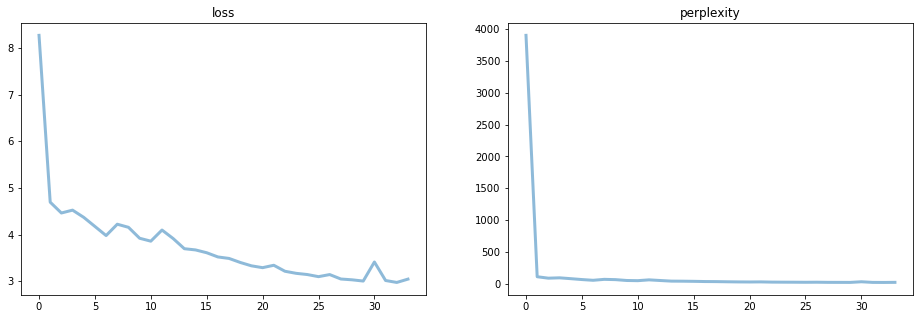

Evaluation log:
Bucket 0: loss=2.751058, ppx=15.659185 (eng_size:05, fr_size:10)
Bucket 1: loss=2.928440, ppx=18.698435 (eng_size:10, fr_size:15)
Bucket 2: loss=3.132909, ppx=22.940613 (eng_size:20, fr_size:25)
Bucket 3: loss=3.122689, ppx=22.707347 (eng_size:40, fr_size:50)
Avg loss=2.983774, Avg ppx=20.001395


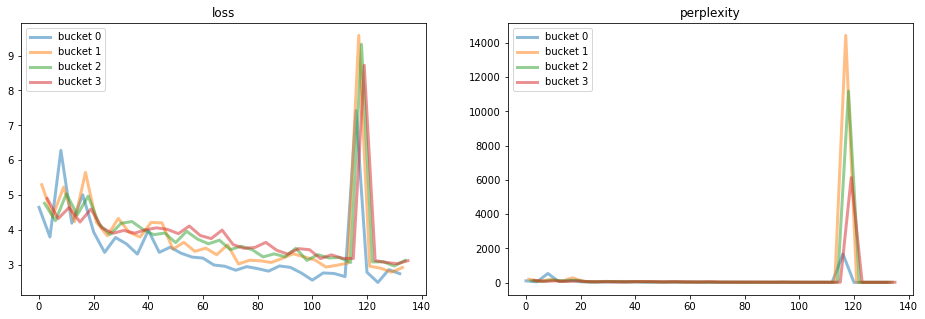

In [101]:
train_log = pd.read_csv('log/train.txt', names=['loss', 'perplexity'])
fig, ax = plt.subplots(ncols=2, figsize=(16,5))
ax[0].set_title('loss')
ax[1].set_title('perplexity')
ax[0].plot(train_log['loss'], alpha=.5, linewidth=3)
ax[1].plot(train_log['perplexity'], alpha=.5, linewidth=3)
print('Training log:')
print('Final loss=%f, final perplexity=%f' %
      (train_log['loss'].values[-1],
       train_log['perplexity'].values[-1]))
plt.show()

test_log = pd.read_csv('log/test.txt', index_col=False, names=['bucket_id', 'eval_loss', 'eval_ppx'])
fig, ax = plt.subplots(ncols=2, figsize=(16,5))
ax[0].set_title('loss')
ax[1].set_title('perplexity')

for b in test_log.bucket_id.unique():
    ax[0].plot(test_log[test_log.bucket_id == b]['eval_loss'], label=f'bucket {b}', alpha=.5, linewidth=3)
    ax[1].plot(test_log[test_log.bucket_id == b]['eval_ppx'], label=f'bucket {b}', alpha=.5, linewidth=3)

for a in ax: a.legend()
print('Evaluation log:')

for i, bs in enumerate(_buckets):
    print(f'Bucket {i}: loss=%f, ppx=%f (eng_size:{bs[0]:02}, fr_size:{bs[1]})' %
          (test_log['eval_loss'].values[i-4], test_log['eval_ppx'].values[i-4]))

print('Avg loss=%f, Avg ppx=%f' %
      (np.mean(test_log['eval_loss'].values[-4:]),
       np.mean(test_log['eval_ppx'].values[-4:])))
    
# _buckets = [(5, 10), (10, 15), (20, 25), (40, 50)]
plt.show()

# Test the network

In [7]:
decode()

Reading model parameters from train/translate.ckpt-18900
> This is great.
Ce sont les résultats .
> My name is tensorflow.
Ce nom est _UNK .
> What is your name?
Ce nom est le nom ?
> I am trained to translate from english to french.
Les participants se _UNK à les _UNK à les _UNK .
> There are many words I don't know yet.
Il y existe que je ne _UNK pas .


KeyboardInterrupt: 